# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2024

Мягкий дедлайн: 22.12.2024 23:59 MSK

Жёсткий дедлайн: 22.12.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [2]:
X = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='plum'>**вопросы**</font> должен быть <font color='plum'>**ответ**</font>. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

#### `partial_fit`

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

#### `plot_history`

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

### Проверка кода

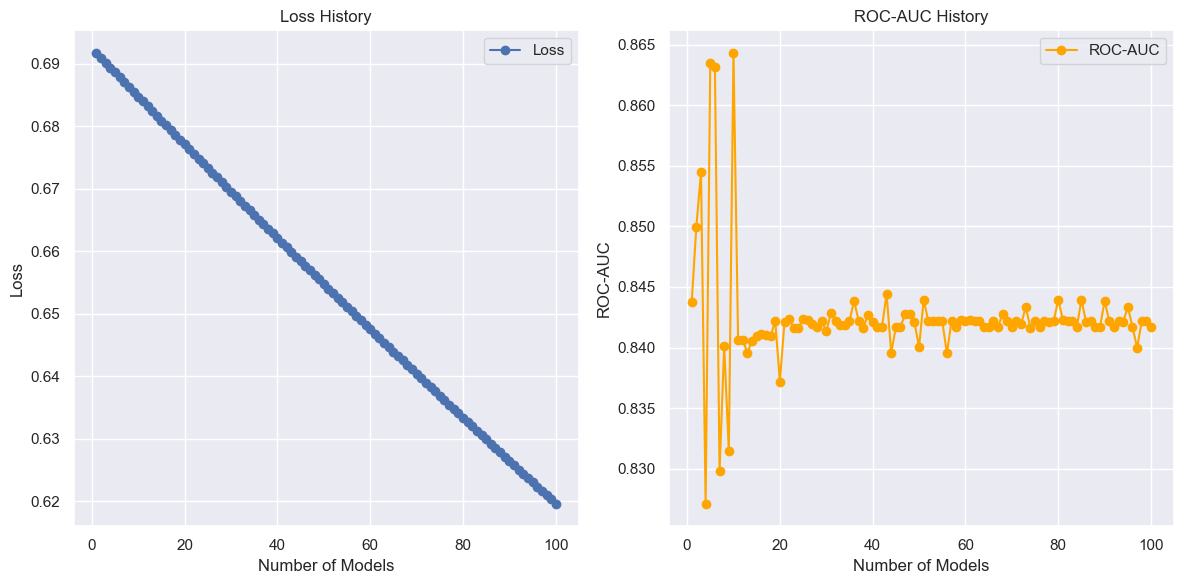

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8417
Test ROC-AUC 0.8342


In [6]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров (2.5 балла + 3.5 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации безотносительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону, для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**дефолтные параметры не подойдут**</font>, они скорее для референса. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотрить именно на них

### 2.1. Борьба с переобучением (0.5 балла)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

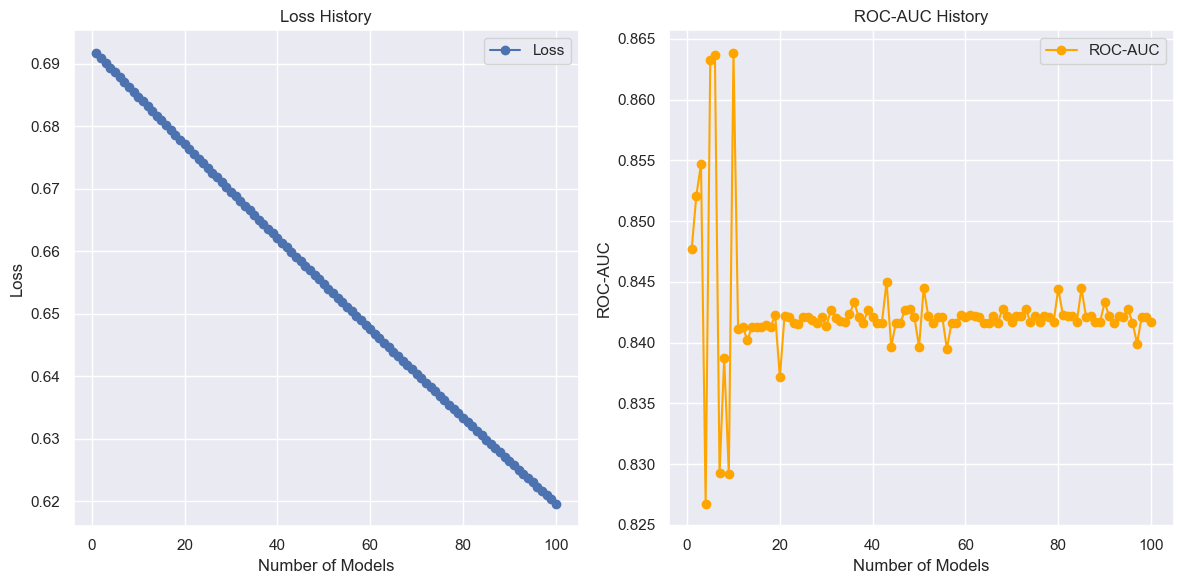

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8417
Test ROC-AUC 0.8334


In [7]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train, X_valid, y_valid)
boosting.plot_history(X_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

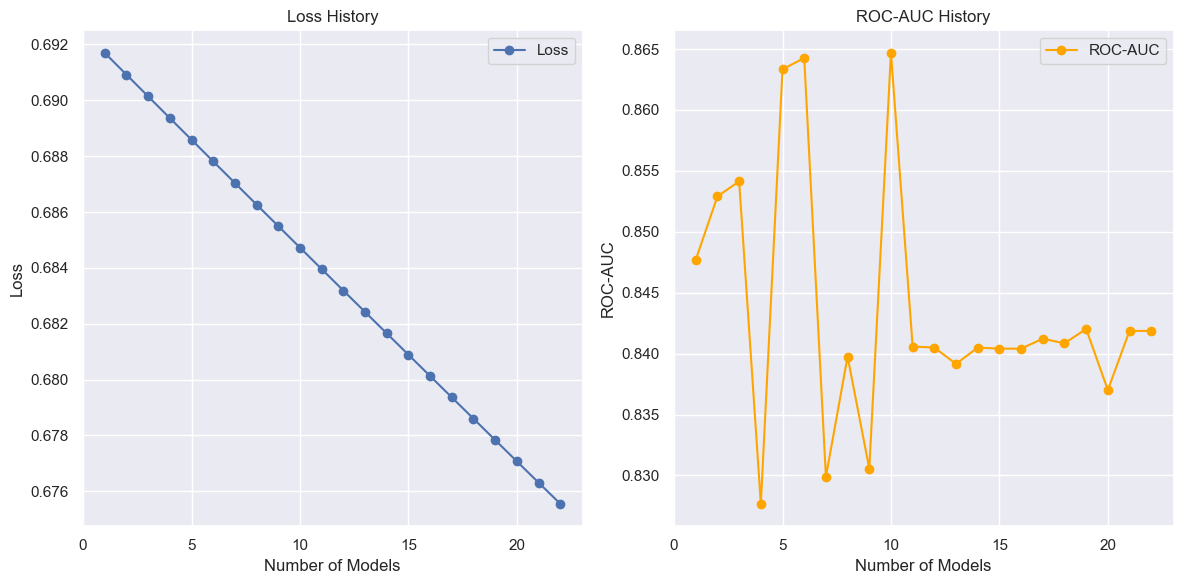

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8419
Test ROC-AUC 0.8330


In [8]:
boosting = Boosting(n_estimators=100, early_stopping_rounds = 20)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. Бустинг линейных моделей (0.5 балла)

**<font color='plum'>Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='plum'>**Ответ:** Не сразу понял, что будет, но в итоге пришел к тому, что произойдет чудо и да!! это имеет бооооольшоооой смысл!!!</font>

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='lightblue'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="gblinear")` | — | — |

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

Теперь возьмите `sklearn.linear_model.SGDClassifier` иобучите на тех же данных. Не забудьте вытащить историю функции потерь

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие параметры у бустинга и линейной модели:

- время обучения
- число итераций до сходимости
- графики функции потерь на трейне и на валидации

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

<font color='plum'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='plum'>**Ответ:** вывод прост, каким бы человек не был, не стоит судить по внешности.</font>

### 2.2. Бутстрап (0.5 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='plum'>**Ответ:** как мы видим бутстрап это реально топчик, он делает свое дело и не задает лишних вопросов. Личено я хочу быть как бутстрап в будущем и стараюсь двигаться в этом направлении </font>

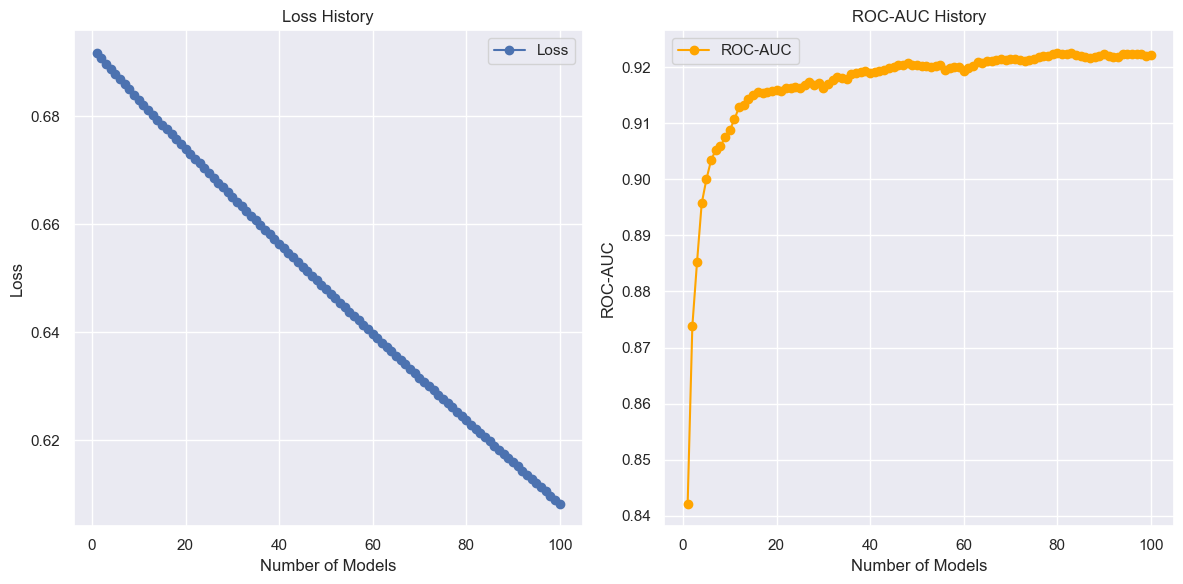

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9221
Test ROC-AUC 0.9164


In [9]:
boosting = Boosting(n_estimators=100, subsample = 0.7)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

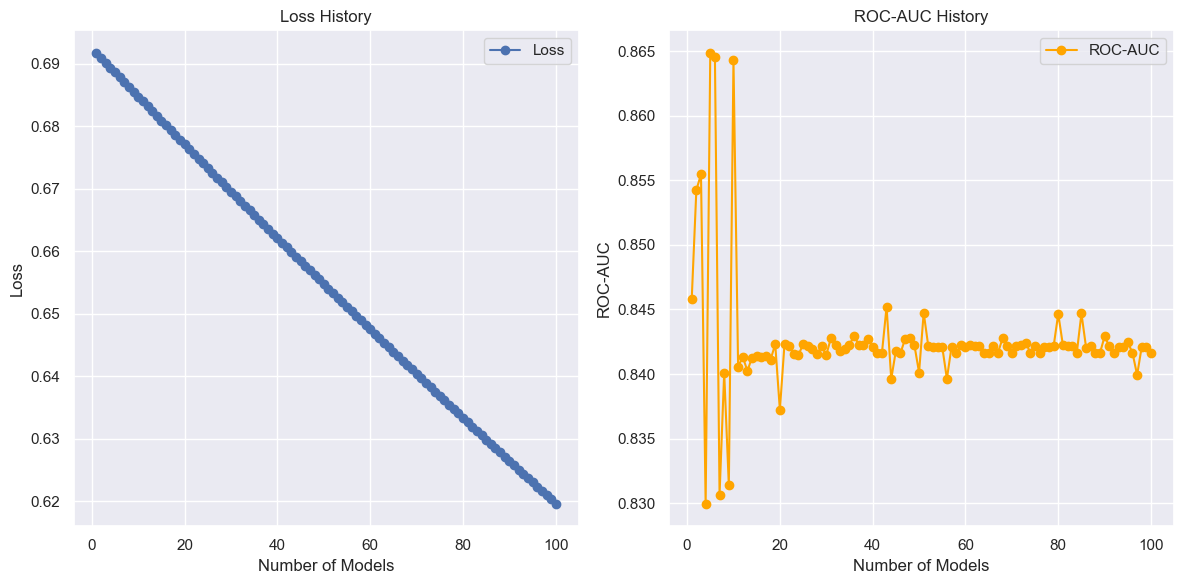

Train ROC-AUC 0.9998
Valid ROC-AUC 0.8416
Test ROC-AUC 0.8337


In [10]:
boosting = Boosting(n_estimators=100, bagging_temperature = 0.8)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

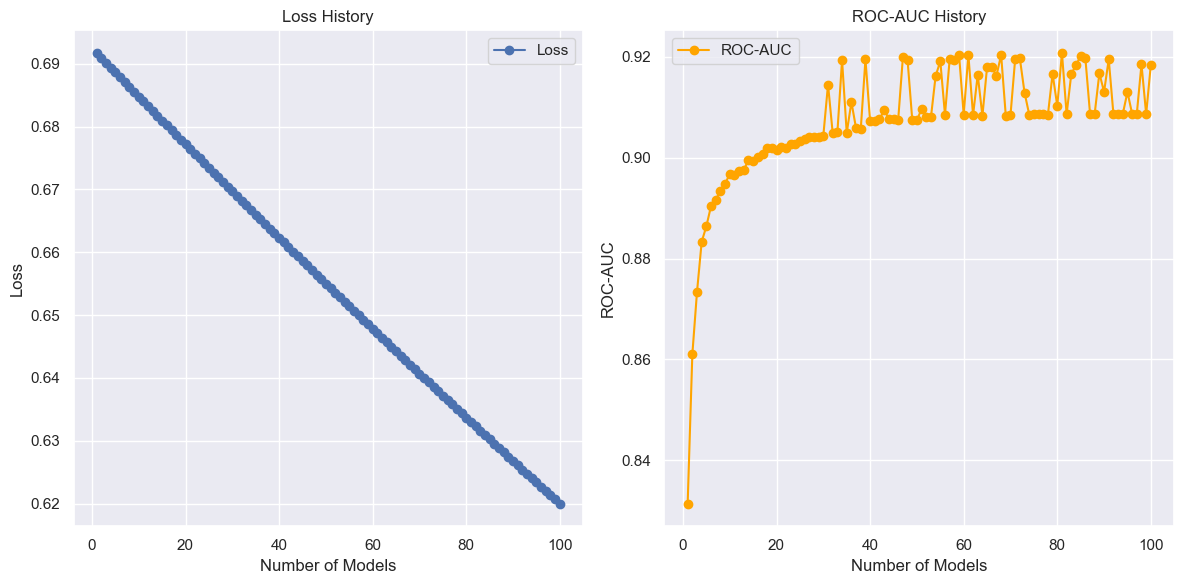

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9185
Test ROC-AUC 0.9175


In [11]:
boosting = Boosting(n_estimators=100, bootstrap_type = "Bayesian")

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. GOSS (0.5 балла)

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='lightgreen'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобъем градиенты на 2 группы. Объекты с большими градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом, с отрицательными — выкидываются. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | `bagging='goss'`| `bootstrap_type='MVS'`|

Параметры, которые нужно сделать:

- `goss: bool | None = False` — GOSS бустинг или нет
- `goss_k: float | int = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float | int = 0.3` — параметры сэмплинга для маленьких градиентов из пункта 2.1

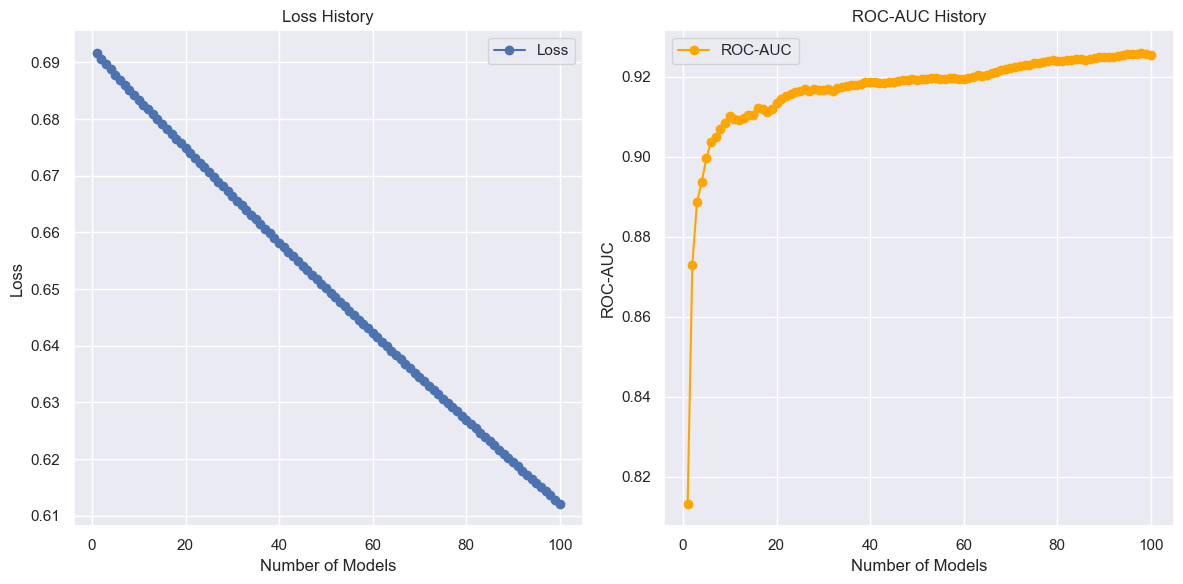

Train ROC-AUC 0.9883
Valid ROC-AUC 0.9255
Test ROC-AUC 0.9228


In [12]:
boosting = Boosting(n_estimators=100, goss = True, goss_k = 0.1, goss_subsample = 0.2)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### 2.3. Работа с признаками (1 балл)

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Ответ**: КВАНТизация не может не помогать. Эх заботаю слупизацию - квантизацией стану </font>

<font color='plum'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

<font color='plum'>**Ответ**: честно скажу, эмпирически выявил, что наны следует заполнять числом 94. Статистики прокрашиваются, лоссы улучшаются, ситуация в мире становится более спокойной.</font>

In [57]:
#

### Бонус. Квантизация (1 балл)

В текущих имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, либо от того, что целевая переменная от бинов зависит опосредованно. Предлагается это исправить следующими способами:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='palegoldenrod'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы энтропия объектов внутри ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Сделать такое разбиение руками непросто, но вам эта задача должна что-то напоминать
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета. (В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лмшь закодированную по формуле часть)

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | — | `feature_border_type="MinEntropy"` |

Нужно добавить опцию:

- `'MinEntropy'` для `quantization_type` — какую квантизацию используем

Реализуйте оба способа подсчета (или один, но тогда балл неполный) и сравните, удалось ли улучшить качество?

In [ ]:
#

### 2.4. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `model.get_score()` | `lightgbm.importance()` | `model.get_feature_importance()` |

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

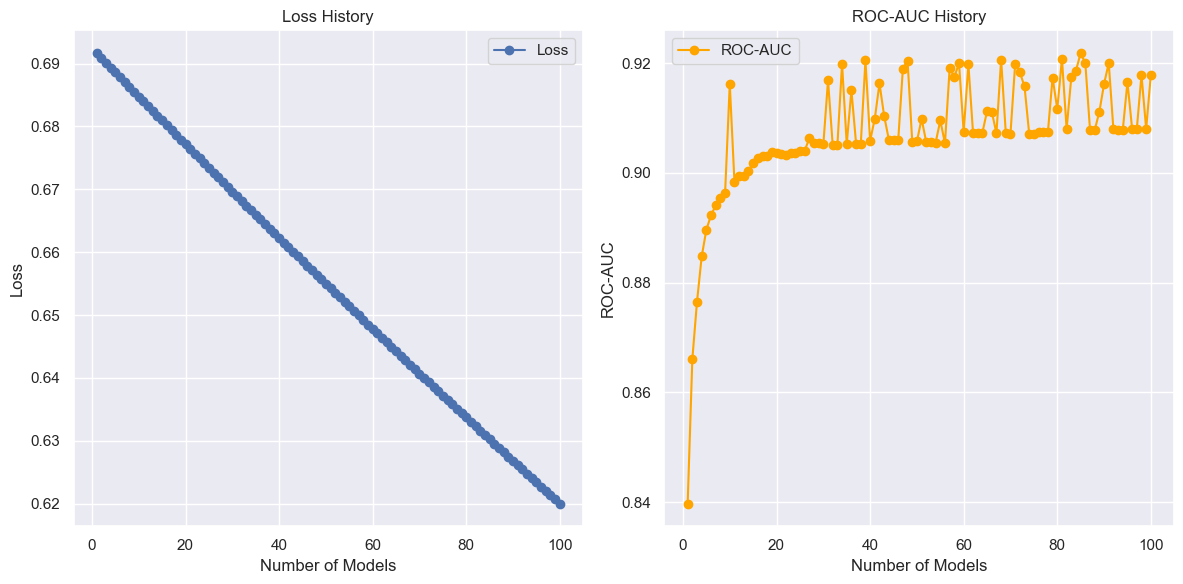

array([ 2.09055504e-03,  4.91140032e-03,  2.39074114e-03,  1.67026324e-03,
        1.84231374e-03,  1.38521884e-03,  8.10447210e-04,  6.05419555e-04,
        5.97929100e-04,  2.03021173e-03,  4.07787198e-03,  5.21299220e-04,
        2.03019195e-03,  6.25082275e-05,  2.98228871e-04,  1.67906079e-03,
        4.61065993e-05,  2.79701467e-04,  1.60624686e-04,  1.23712949e-03,
        4.15478339e-03,  3.47797955e-03,  9.94509225e-04,  6.25718309e-04,
        4.25562550e-03,  1.65823130e-03,  6.33584826e-05,  2.70197547e-03,
        1.67205918e-04,  6.30559874e-04,  1.44441208e-03,  7.32764773e-04,
        4.46198712e-04,  1.04611279e-04,  4.14954595e-04,  1.76751289e-03,
        1.27375935e-02,  7.34593065e-04,  1.07747412e-04,  2.53646362e-05,
        3.61719700e-04,  0.00000000e+00,  3.11357529e-04,  3.20578218e-04,
        6.98489837e-06,  2.10473929e-04,  3.37432828e-04,  1.29059421e-04,
        2.13666405e-04,  0.00000000e+00,  8.24112976e-04,  3.09808179e-04,
        1.78634502e-04,  

In [13]:
boosting = Boosting(n_estimators=100, bootstrap_type = "Bayesian")

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

boosting.feature_importances_

Покажите, какие признаки оказались самыми важными

Text(0.5, 1.0, 'Feature importances for gradient boosting classifier')

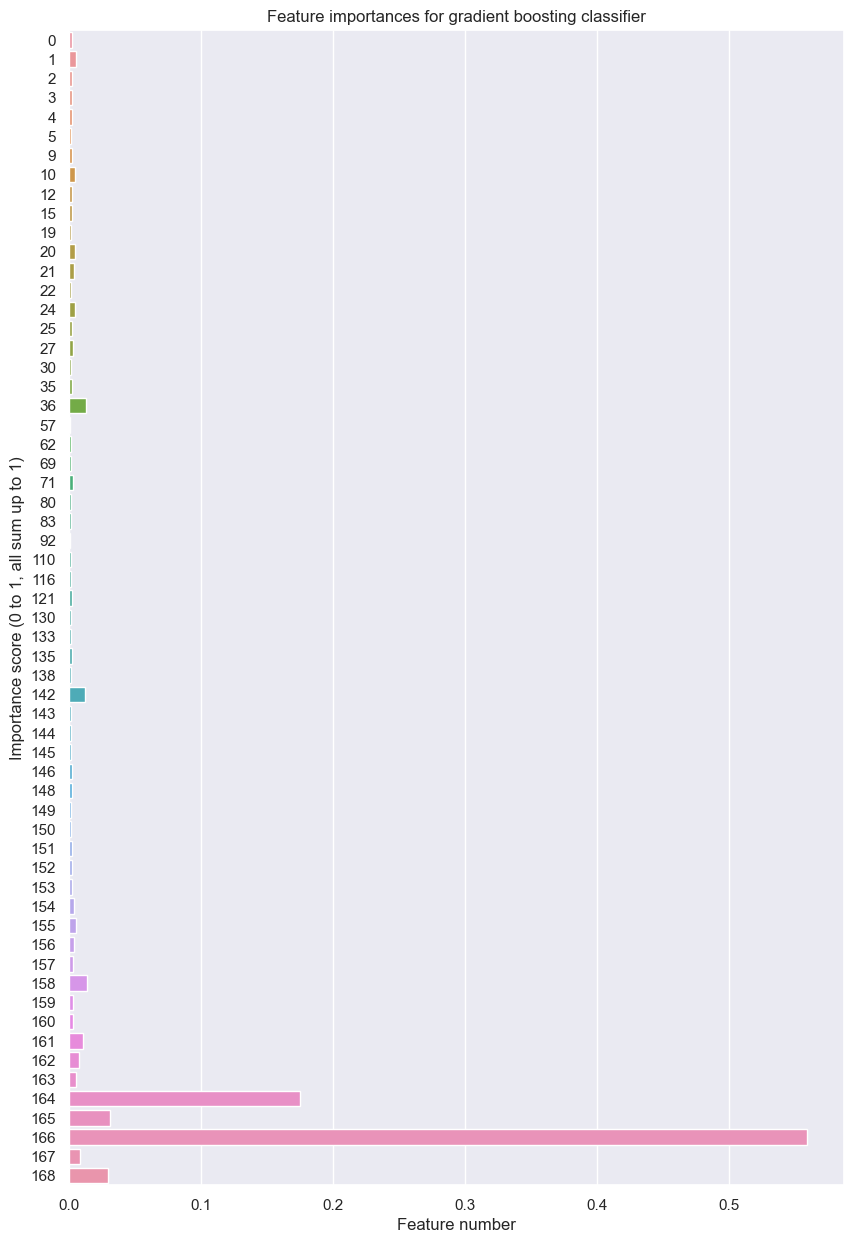

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
feature_imp_boosting = boosting.feature_importances_.reshape((-1, ))
boosting_features_indices = np.argsort(feature_imp_boosting)[::-1]
sns.barplot(x=feature_imp_boosting[boosting_features_indices][:60], y=boosting_features_indices[:60], ax=ax, orient="h")
ax.set_xlabel('Feature number')
ax.set_ylabel('Importance score (0 to 1, all sum up to 1)')
ax.set_title('Feature importances for gradient boosting classifier')

166 самый значимый!!!!!! крутой результат

### Бонус. DART (1.5 балла)

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="dart")` | `LGBMClassifier(boosting_type="dart")` | — |

Параметры, которые нужно добавить:

- `dart: bool | None = False` — DART бустинг или нет
- `dropout_rate: int | float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

------

## Задание 3. Оптимизация (3.5 балла + 0.5 бонус)

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna (1 балл)

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

In [15]:
import optuna

def objective(study, model="custom_boosting"):
    early_stopping_rounds = study.suggest_int("early_stopping_rounds", 2, 32, log=True)
    min_samples_split = study.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = study.suggest_int("min_samples_leaf", 1, 12)
    max_depth = study.suggest_int("max_depth", 2, 32, log=True)
    n_estimators = study.suggest_int("n_estimators", 5, 50)
    learning_rate = study.suggest_float("learning_rate", 1e-10, 1, log=True)
    subsample = study.suggest_float("subsample", 0.1, 1)
    tree_params = {"max_depth": max_depth, "min_samples_split": min_samples_split, "min_samples_leaf": min_samples_leaf}
    boosting = Boosting(base_model_params=tree_params, n_estimators=n_estimators, learning_rate=learning_rate,
                           subsample=subsample, early_stopping_rounds=early_stopping_rounds)
    boosting.fit(X_train, y_train, X_valid, y_valid)
    return boosting.score(X_valid, y_valid)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2024-12-22 22:48:19,405] A new study created in memory with name: no-name-cc00b163-1e8a-4d2e-b7b3-bdf0880d1358
[I 2024-12-22 22:48:27,111] Trial 0 finished with value: 0.9276376021385134 and parameters: {'early_stopping_rounds': 16, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_depth': 22, 'n_estimators': 28, 'learning_rate': 2.0839861695055876e-06, 'subsample': 0.9344990932576721}. Best is trial 0 with value: 0.9276376021385134.
[I 2024-12-22 22:48:30,025] Trial 1 finished with value: 0.934310478731004 and parameters: {'early_stopping_rounds': 16, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_depth': 15, 'n_estimators': 14, 'learning_rate': 0.038450959748868134, 'subsample': 0.7062629081360247}. Best is trial 1 with value: 0.934310478731004.
[I 2024-12-22 22:48:30,182] Trial 2 finished with value: 0.9009943863228379 and parameters: {'early_stopping_rounds': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 3, 'n_estimators': 41, 'learning_rate': 4.18119910

[I 2024-12-22 22:49:11,253] Trial 25 finished with value: 0.9362237425099753 and parameters: {'early_stopping_rounds': 7, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_depth': 10, 'n_estimators': 30, 'learning_rate': 0.014821140410504781, 'subsample': 0.37505277692037947}. Best is trial 6 with value: 0.9366922806152136.
[I 2024-12-22 22:49:11,566] Trial 26 finished with value: 0.927538626456998 and parameters: {'early_stopping_rounds': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_depth': 8, 'n_estimators': 31, 'learning_rate': 0.01696324652149077, 'subsample': 0.2305487960812529}. Best is trial 6 with value: 0.9366922806152136.
[I 2024-12-22 22:49:12,929] Trial 27 finished with value: 0.9335430181037696 and parameters: {'early_stopping_rounds': 6, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_depth': 18, 'n_estimators': 36, 'learning_rate': 0.08381344723860933, 'subsample': 0.5094445650913809}. Best is trial 6 with value: 0.9366922806152136.
[I 2024-12-22 22:49:1

[I 2024-12-22 22:49:39,400] Trial 51 finished with value: 0.9342210813412483 and parameters: {'early_stopping_rounds': 6, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 12, 'n_estimators': 18, 'learning_rate': 0.00495495514387589, 'subsample': 0.5290054344667333}. Best is trial 6 with value: 0.9366922806152136.
[I 2024-12-22 22:49:41,278] Trial 52 finished with value: 0.9320456118253589 and parameters: {'early_stopping_rounds': 10, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_depth': 19, 'n_estimators': 16, 'learning_rate': 0.0004506500721347503, 'subsample': 0.4139052770408555}. Best is trial 6 with value: 0.9366922806152136.
[I 2024-12-22 22:49:42,932] Trial 53 finished with value: 0.9349242875945956 and parameters: {'early_stopping_rounds': 8, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_depth': 15, 'n_estimators': 20, 'learning_rate': 0.01261342402749175, 'subsample': 0.6029134316734571}. Best is trial 6 with value: 0.9366922806152136.
[I 2024-12-22 22:

[I 2024-12-22 22:50:26,593] Trial 76 finished with value: 0.937373935712102 and parameters: {'early_stopping_rounds': 23, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_depth': 13, 'n_estimators': 27, 'learning_rate': 0.00021932978226620417, 'subsample': 0.5095976191361122}. Best is trial 75 with value: 0.9390174109398458.
[I 2024-12-22 22:50:30,880] Trial 77 finished with value: 0.9365398261380408 and parameters: {'early_stopping_rounds': 27, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_depth': 13, 'n_estimators': 27, 'learning_rate': 6.347809307191554e-05, 'subsample': 0.5060480004991204}. Best is trial 75 with value: 0.9390174109398458.
[I 2024-12-22 22:50:35,909] Trial 78 finished with value: 0.9365226650319716 and parameters: {'early_stopping_rounds': 22, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_depth': 16, 'n_estimators': 29, 'learning_rate': 0.0003377019927578733, 'subsample': 0.6296464867671933}. Best is trial 75 with value: 0.9390174109398458.
[I 2024

FrozenTrial(number=95, state=TrialState.COMPLETE, values=[0.9393047596926327], datetime_start=datetime.datetime(2024, 12, 22, 22, 51, 56, 405178), datetime_complete=datetime.datetime(2024, 12, 22, 22, 52, 2, 360917), params={'early_stopping_rounds': 29, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_depth': 15, 'n_estimators': 27, 'learning_rate': 0.0010167105358912924, 'subsample': 0.5990285437683878}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'early_stopping_rounds': IntDistribution(high=32, log=True, low=2, step=1), 'min_samples_split': IntDistribution(high=15, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=12, log=False, low=1, step=1), 'max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'n_estimators': IntDistribution(high=50, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=1e-10, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=95

In [16]:
params = study.best_trial.params
tree_params = {"min_samples_split": params["min_samples_split"],
               "min_samples_leaf": params["min_samples_leaf"],
              "max_depth": params["max_depth"],}
best_model = Boosting(base_model_params=tree_params,
                      n_estimators=params['n_estimators'],
                      subsample=params['subsample'],
                      learning_rate=params['learning_rate'],
                      early_stopping_rounds=params['early_stopping_rounds'])
best_model.fit(X_train, y_train, X_valid, y_valid)
print(f'Train ROC-AUC {best_model.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {best_model.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {best_model.score(X_test, y_test):.4f}')

Train ROC-AUC 0.9799
Valid ROC-AUC 0.9364
Test ROC-AUC 0.9346


### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

In [16]:
# ну что сказать, очень интересное задание и вот так я его решил:
# старался
params = study.best_trial.params
tree_params = {"min_samples_split": params["min_samples_split"],
               "min_samples_leaf": params["min_samples_leaf"],
              "max_depth": params["max_depth"],}
best_model = Boosting(base_model_params=tree_params,
                      n_estimators=params['n_estimators'],
                      subsample=params['subsample'],
                      learning_rate=params['learning_rate'],
                      early_stopping_rounds=params['early_stopping_rounds'])
best_model.fit(X_train, y_train, X_valid, y_valid)
print(f'Train ROC-AUC {best_model.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {best_model.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {best_model.score(X_test, y_test):.4f}')

Train ROC-AUC 0.9799
Valid ROC-AUC 0.9364
Test ROC-AUC 0.9346


### 3.3. Готовые реализации (1 балл)

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [17]:
import xgboost as xgb
import optuna
from sklearn.metrics import roc_auc_score

def objective(study):
    params = {
        "max_depth": study.suggest_int("max_depth", 2, 32, log=True),
        "learning_rate": study.suggest_float("learning_rate", 1e-10, 1, log=True),
        "n_estimators": study.suggest_int("n_estimators", 5, 500),
        "min_child_weight": study.suggest_int("min_child_weight", 1, 20),
        "subsample": study.suggest_float("subsample", 0.1, 1),
        "colsample_bytree": study.suggest_float("colsample_bytree", 0.1, 1),
        "gamma": study.suggest_float("gamma", 0, 10),
        "reg_alpha": study.suggest_float("reg_alpha", 1e-8, 100, log=True),
        "reg_lambda": study.suggest_float("reg_lambda", 1e-8, 100, log=True)
    }

    model = xgb.XGBClassifier(
        **params,
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="auc",
        random_state=42
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=study.suggest_int("early_stopping_rounds", 2, 32, log=True),
        verbose=False
    )

    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_valid_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(study.best_trial)

best_params = study.best_trial.params
best_model = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42
)



[I 2024-12-22 22:52:32,678] A new study created in memory with name: no-name-edcecc0a-f8a7-41f3-9420-827295140c6f
[I 2024-12-22 22:52:32,847] Trial 0 finished with value: 0.5058403634003894 and parameters: {'max_depth': 11, 'learning_rate': 3.927835941175969e-09, 'n_estimators': 17, 'min_child_weight': 6, 'subsample': 0.7761353379195819, 'colsample_bytree': 0.13447307439134162, 'gamma': 4.05265968679873, 'reg_alpha': 6.492356642011809e-08, 'reg_lambda': 0.0013061479499757306, 'early_stopping_rounds': 20}. Best is trial 0 with value: 0.5058403634003894.
[I 2024-12-22 22:52:33,593] Trial 1 finished with value: 0.898858028164967 and parameters: {'max_depth': 15, 'learning_rate': 4.958597606166267e-09, 'n_estimators': 433, 'min_child_weight': 7, 'subsample': 0.4543500996060471, 'colsample_bytree': 0.9213213813937214, 'gamma': 6.894951745786022, 'reg_alpha': 6.081801520809933e-07, 'reg_lambda': 98.53029309629791, 'early_stopping_rounds': 11}. Best is trial 1 with value: 0.898858028164967.
[

[I 2024-12-22 22:52:42,882] Trial 19 finished with value: 0.9436058117881633 and parameters: {'max_depth': 9, 'learning_rate': 0.10084790728744557, 'n_estimators': 148, 'min_child_weight': 19, 'subsample': 0.8231776339622612, 'colsample_bytree': 0.5087954404551768, 'gamma': 8.696223526331057, 'reg_alpha': 1.0492960797798688e-05, 'reg_lambda': 0.01121636514339353, 'early_stopping_rounds': 29}. Best is trial 16 with value: 0.9443205918107203.
[I 2024-12-22 22:52:43,172] Trial 20 finished with value: 0.9307625198250685 and parameters: {'max_depth': 4, 'learning_rate': 0.032749396275152054, 'n_estimators': 34, 'min_child_weight': 3, 'subsample': 0.24764536900480294, 'colsample_bytree': 0.7149615635370465, 'gamma': 7.416384744306586, 'reg_alpha': 1.800616906895484e-07, 'reg_lambda': 3.0425943577350827, 'early_stopping_rounds': 15}. Best is trial 16 with value: 0.9443205918107203.
[I 2024-12-22 22:52:44,145] Trial 21 finished with value: 0.9438831831537005 and parameters: {'max_depth': 9, 'l

[I 2024-12-22 22:53:08,337] Trial 38 finished with value: 0.9391766500403487 and parameters: {'max_depth': 18, 'learning_rate': 0.05636196878216782, 'n_estimators': 182, 'min_child_weight': 4, 'subsample': 0.668643130187898, 'colsample_bytree': 0.4493726391031815, 'gamma': 4.877993707201293, 'reg_alpha': 0.005074630419588511, 'reg_lambda': 8.22017153550195e-07, 'early_stopping_rounds': 5}. Best is trial 27 with value: 0.9458842479404677.
[I 2024-12-22 22:53:08,982] Trial 39 finished with value: 0.9377111714011364 and parameters: {'max_depth': 13, 'learning_rate': 0.010801231194169243, 'n_estimators': 273, 'min_child_weight': 6, 'subsample': 0.42994228302639775, 'colsample_bytree': 0.5701538780015888, 'gamma': 6.1121619108476075, 'reg_alpha': 0.017356727616748852, 'reg_lambda': 3.278360221016343e-05, 'early_stopping_rounds': 22}. Best is trial 27 with value: 0.9458842479404677.
[I 2024-12-22 22:53:10,231] Trial 40 finished with value: 0.939275226626374 and parameters: {'max_depth': 25, 

[I 2024-12-22 22:53:52,389] Trial 57 finished with value: 0.9359583440091378 and parameters: {'max_depth': 7, 'learning_rate': 0.0022698097321624546, 'n_estimators': 480, 'min_child_weight': 4, 'subsample': 0.8232982218731073, 'colsample_bytree': 0.8820322365041816, 'gamma': 5.086952544967586, 'reg_alpha': 0.0014900185408440526, 'reg_lambda': 4.417444142081173e-08, 'early_stopping_rounds': 28}. Best is trial 47 with value: 0.9462973117725987.
[I 2024-12-22 22:53:57,700] Trial 58 finished with value: 0.9420257927433265 and parameters: {'max_depth': 17, 'learning_rate': 0.00023045889155101176, 'n_estimators': 373, 'min_child_weight': 1, 'subsample': 0.966632927938023, 'colsample_bytree': 0.5873963252136244, 'gamma': 3.984683619962682, 'reg_alpha': 0.002819733484440731, 'reg_lambda': 1.3152468154100264e-05, 'early_stopping_rounds': 26}. Best is trial 47 with value: 0.9462973117725987.
[I 2024-12-22 22:53:58,155] Trial 59 finished with value: 0.9385943697204655 and parameters: {'max_depth'

[I 2024-12-22 22:54:15,369] Trial 76 finished with value: 0.9456910857233167 and parameters: {'max_depth': 7, 'learning_rate': 0.07446337575950596, 'n_estimators': 375, 'min_child_weight': 5, 'subsample': 0.8729985398633241, 'colsample_bytree': 0.2632744366146781, 'gamma': 2.3198621730078623, 'reg_alpha': 0.009232334704777662, 'reg_lambda': 1.2832713052374192e-06, 'early_stopping_rounds': 9}. Best is trial 73 with value: 0.9463791263480448.
[I 2024-12-22 22:54:15,798] Trial 77 finished with value: 0.9449236250960822 and parameters: {'max_depth': 5, 'learning_rate': 0.6836063089060429, 'n_estimators': 351, 'min_child_weight': 3, 'subsample': 0.9998779377658763, 'colsample_bytree': 0.328347805022308, 'gamma': 5.261852078670476, 'reg_alpha': 0.013260364955666046, 'reg_lambda': 4.5934491939130075e-06, 'early_stopping_rounds': 8}. Best is trial 73 with value: 0.9463791263480448.
[I 2024-12-22 22:54:16,716] Trial 78 finished with value: 0.9397026578961442 and parameters: {'max_depth': 8, 'le

[I 2024-12-22 22:54:34,020] Trial 95 finished with value: 0.9466816407294507 and parameters: {'max_depth': 7, 'learning_rate': 0.11106593051285717, 'n_estimators': 323, 'min_child_weight': 2, 'subsample': 0.8928991479718775, 'colsample_bytree': 0.39783341116403276, 'gamma': 5.059830673985001, 'reg_alpha': 0.015976684686225182, 'reg_lambda': 6.77950133623769e-06, 'early_stopping_rounds': 20}. Best is trial 95 with value: 0.9466816407294507.
[I 2024-12-22 22:54:34,547] Trial 96 finished with value: 0.9440711571294818 and parameters: {'max_depth': 6, 'learning_rate': 0.5607654983992035, 'n_estimators': 306, 'min_child_weight': 4, 'subsample': 0.8351015627925973, 'colsample_bytree': 0.4055537387399988, 'gamma': 5.606817943961141, 'reg_alpha': 0.016471072863122844, 'reg_lambda': 7.191788673165546e-06, 'early_stopping_rounds': 20}. Best is trial 95 with value: 0.9466816407294507.
[I 2024-12-22 22:54:35,587] Trial 97 finished with value: 0.9460223349800013 and parameters: {'max_depth': 11, 'l

Best trial:
FrozenTrial(number=98, state=TrialState.COMPLETE, values=[0.9472427689883647], datetime_start=datetime.datetime(2024, 12, 22, 22, 54, 35, 588106), datetime_complete=datetime.datetime(2024, 12, 22, 22, 54, 37, 38039), params={'max_depth': 7, 'learning_rate': 0.11092630851512171, 'n_estimators': 327, 'min_child_weight': 3, 'subsample': 0.9573531657758769, 'colsample_bytree': 0.4566742529882387, 'gamma': 4.23074467963864, 'reg_alpha': 0.0074780010713484096, 'reg_lambda': 0.00031772992916329605, 'early_stopping_rounds': 15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=1e-10, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=5, step=1), 'min_child_weight': IntDistribution(high=20, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribut

In [18]:
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

print(f'Train ROC-AUC: {roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]):.4f}')
print(f'Valid ROC-AUC: {roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1]):.4f}')
print(f'Test ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}')


Train ROC-AUC: 0.9801
Valid ROC-AUC: 0.9472
Test ROC-AUC: 0.9404


<font color='plum'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='plum'>**Ответ**: мне больше всего нравится catboost, потому что его создала некая очень великая красная компания ЯНДЕКС ЯНДЕЕЕЕКС YOUNG##YANDEX </font>

### Бонус. Random Forest (0.5 балла)

Если очень захотеть, оптуна может оптимизировать все, что угодно, даже нейросети. Давайте противопоставим бустингу его злейшего врага — алгоритм Random Forest.

Возьмите реализацию случайного леса из <font color='lightgreen'>`lightgbm`</font>. Посмотрите, какие там есть гиперпараметры, переберите что-либо из них вместе с `max_depth` и `n_estimators`.

Сравните его качество и динамику функции потерь (на обучающей и на валидационной выборке) с таковыми у бустинга и сделайте вывод, а нужен ли Random Forest?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

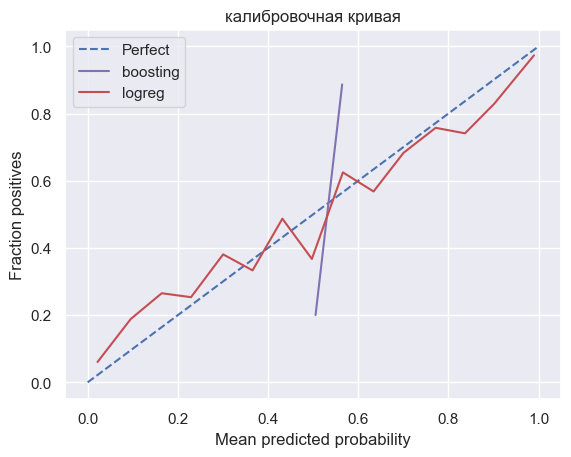

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve


model = LogisticRegression()
model.fit(X_train, y_train)
boosting_pred = boosting.predict_proba(X_test)[:, 1]
logreg_pred = model.predict_proba(X_test)[:, 1]
boosting_true, boosting_pred = calibration_curve(y_test, boosting_pred, n_bins=15)
logreg_true, logreg_pred = calibration_curve(y_test, logreg_pred, n_bins=15)

plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction positives')
plt.title('калибровочная кривая')
plt.plot(boosting_pred, boosting_true, label='boosting', color='m')
plt.plot(logreg_pred, logreg_true, label='logreg', color='r')
plt.legend()
plt.show()

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2025 года?

![](крутые_чуваки.jpg)

в 2025 хочу новый альбом плейбой карти и френк оушена